In [2]:
# デバッグモード
debug = True

res = AppRes()
excel = "ticks_20260122.xlsx"
# code = "285A"
# code = "7011"
# code = "7203"
code = "8306"
# code = "9984"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
THRESHOLD_PM_MIN = dict_setting["THRESHOLD_PM_MIN"]
THRESHOLD_DDR_MIN = dict_setting["THRESHOLD_DDR_MIN"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/22
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 50
PERIOD_MA_2 : 1000
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.03
PERIOD_RR : 30
TURBULENCE : 15
LOSSCUT_1 : -10
THRESHOLD_PM_MIN : 5.0
THRESHOLD_DDR_MIN : 0.5
N_MINUS_MAX : 120


In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

output/2026/01/22/8306_trend_profit.png


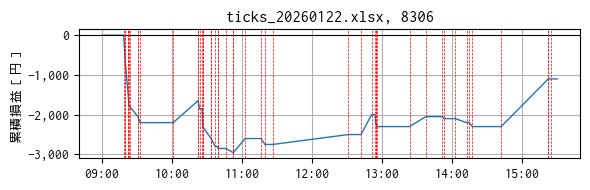

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [8]:
df_tech["slope1"].describe()

count    19245.000000
mean         0.023047
std          0.028947
min          0.000000
25%          0.007333
50%          0.016333
75%          0.030000
max          0.800000
Name: slope1, dtype: float64

output/2026/01/22/8306_hist_slope.png


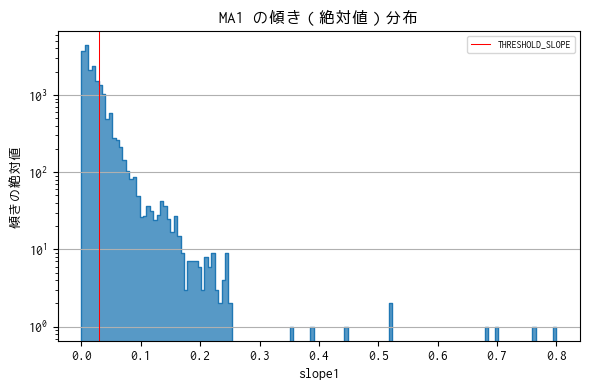

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-22 09:03:00    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:01    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:02    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:03    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:04    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-22 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0

[19245 rows x 8 columns]
